In [1]:
import os
import sys
import subprocess as subp
import json
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
from matplotlib import gridspec
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import nibabel as nib

In [2]:
import collections
import multiprocessing 
import datetime

In [27]:
%reload_ext oct2py.ipython

In [3]:
# load good stuff
%matplotlib inline
#%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

In [5]:
from oct2py import octave

In [6]:
octave.eval( " plot3([2,1],[5,2],[10,12])  " )

In [9]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [11]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [6]:
# Set path 
path_root = '/home/yassinebha/data/data_disk/Drive/HCP2/'
path_pheno = os.path.join(path_root,"subtypes_scores/26-10-2016/pheno")
path_asso = '/scratch/yassinebha/pleio/pleio_association/'
path_out = os.path.join(path_root,'Solar_heritability/MetaSubt')
# Set file pattern
pedig_file_ptrn = 'GenMetSub_pedigre.csv'
pheno_file_ptrn = 'GenMetSub_pheno.csv'
pheno_clust = os.path.join(path_pheno,'hcp_pleio_RhoP_pheno_nonan_norm_python_13_1200.csv')

In [7]:
# Load subtypes weights
sbt_weight_df = pd.read_csv(os.path.join(path_pheno,pheno_file_ptrn)).drop(['ZygositySG','Mother_ID'],axis=1)
sbt_weight_df.count()

ID            726
Age_in_Yrs    726
Gender        726
BMI           726
GeMetSub_1    726
GeMetSub_2    726
GeMetSub_3    726
GeMetSub_4    726
GeMetSub_5    726
GeMetSub_6    726
GeMetSub_7    726
GeMetSub_8    726
dtype: int64

In [8]:
# Clusters list
list_weight = [x for x in sbt_weight_df.columns.get_values() if x not in ['ID','Age_in_Yrs','Gender','BMI']]
list_weight

['GeMetSub_1',
 'GeMetSub_2',
 'GeMetSub_3',
 'GeMetSub_4',
 'GeMetSub_5',
 'GeMetSub_6',
 'GeMetSub_7',
 'GeMetSub_8']

In [9]:
# Load phenotype clustered file
pheno_clust_df = pd.read_csv(pheno_clust)
pheno_clust_df.count()

ID            1154
Cluster_1     1154
Cluster_2     1154
Cluster_3     1154
Cluster_4     1154
Cluster_5     1154
Cluster_6     1154
Cluster_7     1154
Cluster_8     1154
Cluster_9     1154
Cluster_10    1154
Cluster_11    1154
Cluster_12    1154
Cluster_13    1154
dtype: int64

In [10]:
# Clusters list
list_pheno_clust = [x for x in pheno_clust_df.columns.get_values() if x!='ID']
list_pheno_clust

['Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Cluster_7',
 'Cluster_8',
 'Cluster_9',
 'Cluster_10',
 'Cluster_11',
 'Cluster_12',
 'Cluster_13']

In [11]:
# Merge pheno clusters with subtypes
sbt_pheno_df = pd.merge(sbt_weight_df,pheno_clust_df,how='inner',on='ID')
sbt_pheno_df.count()

ID            726
Age_in_Yrs    726
Gender        726
BMI           726
GeMetSub_1    726
GeMetSub_2    726
GeMetSub_3    726
GeMetSub_4    726
GeMetSub_5    726
GeMetSub_6    726
GeMetSub_7    726
GeMetSub_8    726
Cluster_1     726
Cluster_2     726
Cluster_3     726
Cluster_4     726
Cluster_5     726
Cluster_6     726
Cluster_7     726
Cluster_8     726
Cluster_9     726
Cluster_10    726
Cluster_11    726
Cluster_12    726
Cluster_13    726
dtype: int64

### Pleiothropy estimate:

In [12]:
import collections
import multiprocessing 
import datetime

In [14]:
#initiate empty dictionary
Pleio_Asso = collections.namedtuple('Pleio_Asso', [
    'out_dir',
    'pedig_f',
    'pheno_f',
    'var_1',
    'var_2'
])
pleio_asso = []

# pleio root folder
path_pleio = os.path.join(path_out,'pleio_GenMetSub_{}'.format(str(datetime.date.today())))
if not os.path.exists(path_pleio):
    os.makedirs(path_pleio)

# create ouput folders and populate RhoG dictionnary
for ix_clust, clust in enumerate(list_pheno_clust):
    for ix_wei, wei in enumerate(list_weight):
        print(clust,wei)
        pheno_1 = clust
        pheno_2 = wei
        #cov_1 = '{}_FD_scrubbed_mean'.format(str.upper(task_name))

        # output result folder 
        path_pleio_contrast = os.path.join(path_pleio,'{}_{}'.format(clust,wei))
        if not os.path.exists(path_pleio_contrast):
            os.makedirs(path_pleio_contrast)

        # copy needed files to output folder
        if not os.path.isfile(os.path.join(path_pleio_contrast,'se_univ_polygen.tcl')):
            subp.run(['cp',os.path.join(path_out,'se_univ_polygen.tcl'),path_pleio_contrast])
        if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_run.sh')):
            subp.run(['cp',os.path.join(path_out,'pleio_run_yu.sh'),path_pleio_contrast])

        # pedegree
        if not os.path.isfile(os.path.join(path_pleio_contrast,pedig_file_ptrn)):
            subp.run(['cp',os.path.join(path_pheno,pedig_file_ptrn),path_pleio_contrast]) 

        pedig_f = os.path.join(path_pleio_contrast,pedig_file_ptrn)

        # save pheno cov to file
        pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
        if not os.path.isfile(pheno_f):
            sbt_pheno_df[['ID','Age_in_Yrs','Gender',pheno_1,pheno_2]].to_csv(pheno_f,index=False)   

        # collect all pleio contrasts in dictionary
        pleio_asso.append(Pleio_Asso(out_dir = path_pleio_contrast,
                                      pedig_f = pedig_f,
                                      pheno_f = pheno_f,
                                      var_1 = pheno_1,
                                      var_2 = pheno_2)) 

Cluster_1 GeMetSub_1
Cluster_1 GeMetSub_2
Cluster_1 GeMetSub_3
Cluster_1 GeMetSub_4
Cluster_1 GeMetSub_5
Cluster_1 GeMetSub_6
Cluster_1 GeMetSub_7
Cluster_1 GeMetSub_8
Cluster_2 GeMetSub_1
Cluster_2 GeMetSub_2
Cluster_2 GeMetSub_3
Cluster_2 GeMetSub_4
Cluster_2 GeMetSub_5
Cluster_2 GeMetSub_6
Cluster_2 GeMetSub_7
Cluster_2 GeMetSub_8
Cluster_3 GeMetSub_1
Cluster_3 GeMetSub_2
Cluster_3 GeMetSub_3
Cluster_3 GeMetSub_4
Cluster_3 GeMetSub_5
Cluster_3 GeMetSub_6
Cluster_3 GeMetSub_7
Cluster_3 GeMetSub_8
Cluster_4 GeMetSub_1
Cluster_4 GeMetSub_2
Cluster_4 GeMetSub_3
Cluster_4 GeMetSub_4
Cluster_4 GeMetSub_5
Cluster_4 GeMetSub_6
Cluster_4 GeMetSub_7
Cluster_4 GeMetSub_8
Cluster_5 GeMetSub_1
Cluster_5 GeMetSub_2
Cluster_5 GeMetSub_3
Cluster_5 GeMetSub_4
Cluster_5 GeMetSub_5
Cluster_5 GeMetSub_6
Cluster_5 GeMetSub_7
Cluster_5 GeMetSub_8
Cluster_6 GeMetSub_1
Cluster_6 GeMetSub_2
Cluster_6 GeMetSub_3
Cluster_6 GeMetSub_4
Cluster_6 GeMetSub_5
Cluster_6 GeMetSub_6
Cluster_6 GeMetSub_7
Cluster_6 GeM

In [15]:
# run one job for debuging
subp.run(['bash', os.path.join(pleio_asso[0].out_dir,'pleio_run_yu.sh'),
              pleio_asso[0].out_dir,
              pleio_asso[0].pedig_f,
              pleio_asso[0].pheno_f,
              pleio_asso[0].var_1,
              pleio_asso[0].var_2
         ])

CompletedProcess(args=['bash', '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/MetaSubt/pleio_GenMetSub_2020-02-29/Cluster_1_GeMetSub_1/pleio_run_yu.sh', '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/MetaSubt/pleio_GenMetSub_2020-02-29/Cluster_1_GeMetSub_1', '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/MetaSubt/pleio_GenMetSub_2020-02-29/Cluster_1_GeMetSub_1/GenMetSub_pedigre.csv', '/home/yassinebha/data/data_disk/Drive/HCP2/Solar_heritability/MetaSubt/pleio_GenMetSub_2020-02-29/Cluster_1_GeMetSub_1/pheno_cov.csv', 'Cluster_1', 'GeMetSub_1'], returncode=0)

In [16]:
def run_pleio(x):
    subp.run(['bash', os.path.join(x.out_dir,'pleio_run_yu.sh'),
              x.out_dir,
              x.pedig_f,
              x.pheno_f,
              x.var_1,
              x.var_2
             ])
    
    # collect result
    RhoE = ''
    RhoE_pval=''
    RhoG = ''
    RhoG_pval_0 = ''
    RhoG_pval_1 = ''
    results = ''
    
    contrast_name = '{}_{}'.format(x.var_1,x.var_2)
    fp = open(os.path.join(x.out_dir,'solar_pleio.out'))
    for i,line in enumerate(fp):
        if 'CONVERGENCE FAILURE' in line:
            print('{}_{}'.format(x.var1,x.var_2))
            print(line)
            results = {'contrast_name' : contrast_name,'no_converg' : True}
            break
        if 'RhoE is ' in line:
            RhoE = float(line.strip('\n').split(' ')[3])
            RhoE_pval = float(line.strip('\n').split(' ')[-1])
        if 'RhoG is ' in line:
            RhoG = float(line.strip('\n').split(' ')[-1])
            #print(out_dir)
            #print(line.strip('\t ').strip('\n'))
        if 'RhoG different from zero' in line:
            RhoG_pval_0 = float(line.strip('\n').split(' ')[-1])
            #print(line.strip('\t '))
        if 'RhoG different from -1.0' in line:
            RhoG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
        elif 'RhoG different from 1.0' in line:
            RohG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
    return results

In [17]:
# function from http://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=12, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

In [18]:
result = parallel_process(pleio_asso,run_pleio,use_kwargs=False)

100%|██████████| 101/101 [03:54<00:00, 2.32s/it] 
101it [00:00, 130185.83it/s]


In [238]:
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    result = executor.map(run_pleio,pleio_asso)

In [239]:
#pool = multiprocessing.Pool()
#result = pool.map(run_pleio,pleio_asso)

In [19]:
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = True):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    # replace 0's by 1
    flatt[flatt == 0] =1
    fdr_1d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_1d = [-np.log10(ii) for ii in fdr_1d] 
    fdr_2d = np.reshape(fdr_1d,(row,col))
    return fdr_2d

In [97]:
#Initiate no convergence result stack

No_converge = collections.namedtuple('No_converge', ['var_1',
                                                     'var_2',
                                                     'pedig_f',
                                                     'pheno_f',
                                                     'out_dir'])
no_converges = []
all_resu = dict()
H2r = dict()
trial = 'GenMetSub'
# initiate empty matrix
RhoG = np.zeros((len(list_pheno_clust),len(list_weight)))
RhoG_pval_0 = np.zeros((len(list_pheno_clust),len(list_weight)))
RhoG_pval_1 = np.zeros((len(list_pheno_clust),len(list_weight)))
RhoG_pval_m1 = np.zeros((len(list_pheno_clust),len(list_weight)))
RhoE = np.zeros((len(list_pheno_clust),len(list_weight)))
RhoE_pval = np.zeros((len(list_pheno_clust),len(list_weight)))
RhoP = np.zeros((len(list_pheno_clust),len(list_weight)))
RhoP_pval = np.zeros((len(list_pheno_clust),len(list_weight)))

# Loop over cluster
for ix_clust, clust in enumerate(list_pheno_clust):
    for ix_wei, wei in enumerate(list_weight):
        
        pheno_1 = clust
        pheno_2 = wei
        
        # output result folder
        out_dir = os.path.join(path_pleio,'{}_{}'.format(clust,wei)) 
        # pheno cov file
        pheno_f= os.path.join(out_dir,'pheno_cov.csv')
        # pedig file
        pedig_f = os.path.join(out_dir,pedig_file_ptrn)

        #grab results from text file
        fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
        for i,line in enumerate(fp):
            if 'CONVERGENCE FAILURE' in line:
                print(out_dir)
                print(line)
                count+=1
                no_converges.append(No_converge(var_1 = pheno_1,
                                                var_2 = pheno_2,
                                                out_dir = out_dir,
                                                pedig_f = pedig_f,
                                                pheno_f = pedig_f))
                break


            if 'H2r({}_norm) is '.format(pheno_1) in line:
                H2r.update({'{}'.format(pheno_1):{'h2r':float(line.strip('\n').split(' ')[3])}})

            if 'H2r({}_norm) Std. Error: '.format(pheno_1) in line:
                H2r['{}'.format(pheno_1)].update({'std':float(line.strip('\n').split(' ')[-1])})

            if 'H2r({}_norm) is '.format(pheno_2) in line:
                H2r.update({'{}'.format(pheno_2):{'h2r':float(line.strip('\n').split(' ')[3])}})

            if 'H2r({}_norm) Std. Error: '.format(pheno_2) in line:
                H2r['{}'.format(pheno_2)].update({'std':float(line.strip('\n').split(' ')[-1])})

            if 'RhoE is ' in line:
                RhoE[ix_clust,ix_wei] = float(line.strip('\n').split(' ')[3])
                RhoE_pval[ix_clust,ix_wei] = float(line.strip('\n').split(' ')[-1])

            if 'RhoG is ' in line:
                RhoG[ix_clust,ix_wei] = float(line.strip('\n').split(' ')[-1])

                #print(out_dir)
                #print(line.strip('\t ').strip('\n'))
            if 'RhoG different from zero' in line:
                RhoG_pval_0[ix_clust,ix_wei] = float(line.strip('\n').split(' ')[-1])

                #print(line.strip('\t '))
            if 'RhoG different from -1.0' in line:
                RhoG_pval_m1[ix_clust,ix_wei] = float(line.strip('\n').split(' ')[-1])

            elif 'RhoG different from 1.0' in line:
                RhoG_pval_1[ix_clust,ix_wei] = float(line.strip('\n').split(' ')[-1])

            if 'RhoP is ' in line:
                #print(float(line.strip('\n').split(' ')[-1]))
                RhoP[ix_clust,ix_wei] = float(line.strip('\n').split(' ')[-1])

            if 'RhoP different from zero' in line:
                RhoP_pval[ix_clust,ix_wei] = float(line.strip('\n').split(' ')[-1])
                #print(float(line.strip('\n').split(' ')[-1]))
                break
# save matrices
all_resu.update({'{}'.format(trial):{'RhoE':RhoE,
                                     'RhoE_pval':RhoE_pval,
                                     'RhoE_pval_fdr':fdr_transf(RhoE_pval),
                                     'RhoG':RhoG,
                                     'RhoG_pval_0':RhoG_pval_0,
                                     'RhoG_pval_0_fdr':fdr_transf(RhoG_pval_0),
                                     'RhoG_pval_1':RhoG_pval_1,
                                     'RhoG_pval_1_fdr':fdr_transf(RhoG_pval_1),
                                     'RhoG_pval_m1':RhoG_pval_m1,
                                     'RhoG_pval_m1_fdr':fdr_transf(RhoG_pval_m1),
                                     'RhoP':RhoP,
                                     'RhoP_pval':RhoP_pval,
                                     'RhoP_pval_fdr':fdr_transf(RhoP_pval),
                                     'H2r':H2r,
                                     'list_pheno_clust' :list_pheno_clust,
                                     'list_weight':list_weight
                                    }})

In [167]:
# Clusters from RhoP corelation 
dict_clusters = {'Cluster_1' : 'DesorExt',
                 'Cluster_2' : 'Somatic',
                 'Cluster_3' : 'DesorInt',
                 'Cluster_4' : 'NegAff',
                 'Cluster_5' : 'PosAff',
                 'Cluster_6' : 'SelfReg',
                 'Cluster_7' : 'FluInt',
                 'Cluster_8' : 'Mix1',
                 'Cluster_9' : 'AcadSkil',
                 'Cluster_10' : 'Execut',
                 'Cluster_11' : 'Mix2',
                 'Cluster_12' : 'Physio',
                 'Cluster_13' : 'Speed'}

In [191]:
def mm2in(mm):
    return mm/25.4

In [192]:
RhoG_df = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG'],columns=list_weight,index=list_pheno_clust)
RhoG_df.rename(index=dict_clusters,inplace=True)
RhoG_df.head()

,GeMetSub_1,GeMetSub_2,GeMetSub_3,GeMetSub_4,GeMetSub_5,GeMetSub_6,GeMetSub_7,GeMetSub_8
DesorExt,-0.042916,-0.104803,0.309231,-0.064036,-0.115331,0.110137,0.025505,0.101319
Somatic,-0.105691,-0.010513,-0.258655,-0.026967,-0.271976,0.067562,-0.013735,0.018436
DesorInt,-0.084486,-0.084012,-0.356556,-0.079792,-0.295468,0.191109,-0.102157,0.087820
NegAff,0.015576,-0.094860,-0.583919,-0.067689,-0.148201,0.070203,-0.011366,0.107539
PosAff,0.059444,0.119670,0.280894,0.284866,0.142402,0.028327,0.069174,-0.150318


In [193]:
RhoP_df = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP'],columns=list_weight,index=list_pheno_clust)
RhoP_df.rename(index=dict_clusters,inplace=True)
RhoP_df.head()

,GeMetSub_1,GeMetSub_2,GeMetSub_3,GeMetSub_4,GeMetSub_5,GeMetSub_6,GeMetSub_7,GeMetSub_8
DesorExt,0.015454,-0.028889,-0.018519,-0.041126,0.027973,0.039180,-0.010985,0.031662
Somatic,-0.048081,-0.076943,-0.034674,-0.032530,0.045144,0.028301,0.065611,0.077583
DesorInt,-0.024137,-0.088572,-0.033550,-0.037409,0.008915,0.043767,0.066476,0.087062
NegAff,-0.040398,-0.097607,-0.032637,-0.088290,0.014004,0.064638,0.069294,0.101683
PosAff,0.049795,0.118291,-0.007693,0.062569,-0.001881,-0.051411,-0.045222,-0.120808


In [253]:
RhoE_df = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE'],columns=list_weight,index=list_pheno_clust)
RhoE_df.rename(index=dict_clusters,inplace=True)
RhoE_df.head()

,GeMetSub_1,GeMetSub_2,GeMetSub_3,GeMetSub_4,GeMetSub_5,GeMetSub_6,GeMetSub_7,GeMetSub_8
DesorExt,0.050913,0.041148,-0.059327,-0.030134,0.083773,0.008575,-0.034825,-0.032241
Somatic,-0.022974,-0.136448,-0.017794,-0.034723,0.140175,0.015502,0.106406,0.132329
DesorInt,0.014346,-0.099801,0.000134,-0.016209,0.132789,-0.023179,0.177271,0.092993
NegAff,-0.078946,-0.105806,0.035246,-0.100590,0.085122,0.063046,0.128710,0.100721
PosAff,0.043169,0.123514,-0.049769,-0.061710,-0.063867,-0.091262,-0.130446,-0.095866


In [194]:
RhoG_fdr_0_df = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_0_fdr'],columns=list_weight,index=list_pheno_clust)
RhoG_fdr_0_df.rename(index=dict_clusters,inplace=True)
RhoG_fdr_0_df.head()

,GeMetSub_1,GeMetSub_2,GeMetSub_3,GeMetSub_4,GeMetSub_5,GeMetSub_6,GeMetSub_7,GeMetSub_8
DesorExt,0.041243,0.130256,0.064910,0.051833,0.064910,0.064910,0.015213,0.130256
Somatic,0.064910,0.009781,0.051833,0.013219,0.160034,0.041243,0.009781,0.013219
DesorInt,0.064910,0.090171,0.064910,0.064910,0.296919,0.160034,0.071072,0.098612
NegAff,0.011024,0.130256,0.160034,0.051833,0.080977,0.051833,0.009781,0.160034
PosAff,0.051833,0.160034,0.064910,0.461805,0.071072,0.015213,0.064910,0.296919


In [262]:
RhoG_fdr_1_df = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_1_fdr'],columns=list_weight,index=list_pheno_clust)
RhoG_fdr_1_df.rename(index=dict_clusters,inplace=True)
RhoG_fdr_1_df.head()

,GeMetSub_1,GeMetSub_2,GeMetSub_3,GeMetSub_4,GeMetSub_5,GeMetSub_6,GeMetSub_7,GeMetSub_8
DesorExt,-0.000000,-0.000000,0.089845,-0.000000,-0.000000,2.988683,4.272311,4.265513
Somatic,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,2.175685,-0.000000,2.249744
DesorInt,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,2.843988,-0.000000,5.619789
NegAff,5.527035,-0.000000,-0.000000,-0.000000,-0.000000,3.065356,-0.000000,6.356981
PosAff,6.062148,6.062148,0.094947,3.512532,1.862464,2.843988,5.380907,-0.000000


In [263]:
RhoG_fdr_m1_df = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_m1_fdr'],columns=list_weight,index=list_pheno_clust)
RhoG_fdr_m1_df.rename(index=dict_clusters,inplace=True)
RhoG_fdr_m1_df.head()

,GeMetSub_1,GeMetSub_2,GeMetSub_3,GeMetSub_4,GeMetSub_5,GeMetSub_6,GeMetSub_7,GeMetSub_8
DesorExt,4.304518,4.304518,-0.000000,4.304518,2.079631,-0.0,-0.000000,-0.000000
Somatic,2.286562,2.286562,0.092571,2.268252,1.404223,-0.0,2.151940,-0.000000
DesorInt,5.681937,5.681937,0.092571,4.765483,1.718986,-0.0,4.304518,-0.000000
NegAff,-0.000000,6.400418,0.072513,4.895816,1.943525,-0.0,5.435264,-0.000000
PosAff,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.000000,5.761118


In [195]:
RhoP_fdr_df = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP_pval_fdr'],columns=list_weight,index=list_pheno_clust)
RhoP_fdr_df.rename(index=dict_clusters,inplace=True)
RhoP_fdr_df.head()

,GeMetSub_1,GeMetSub_2,GeMetSub_3,GeMetSub_4,GeMetSub_5,GeMetSub_6,GeMetSub_7,GeMetSub_8
DesorExt,0.099724,0.224296,0.130289,0.306455,0.221646,0.293348,0.066377,0.244812
Somatic,0.395486,0.835810,0.276213,0.258522,0.352980,0.224296,0.677641,0.841017
DesorInt,0.188342,1.056171,0.267658,0.277013,0.057687,0.349777,0.677641,1.045237
NegAff,0.294058,1.197970,0.259327,1.056171,0.093938,0.661354,0.689293,1.285486
PosAff,0.405946,1.721506,0.051593,0.629536,0.013289,0.431943,0.352980,1.743367


In [254]:
RhoE_fdr_df = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE_pval_fdr'],columns=list_weight,index=list_pheno_clust)
RhoE_fdr_df.rename(index=dict_clusters,inplace=True)
RhoE_fdr_df.head()

,GeMetSub_1,GeMetSub_2,GeMetSub_3,GeMetSub_4,GeMetSub_5,GeMetSub_6,GeMetSub_7,GeMetSub_8
DesorExt,0.021192,0.021192,0.039947,0.021192,0.095460,0.005359,0.021192,0.021192
Somatic,0.021192,0.184970,0.021192,0.021192,0.184970,0.021192,0.121467,0.184970
DesorInt,0.018396,0.121467,0.000850,0.021192,0.184970,0.021192,0.184970,0.121467
NegAff,0.064805,0.121467,0.021192,0.121467,0.097866,0.039947,0.184970,0.121467
PosAff,0.021192,0.165729,0.026063,0.039947,0.039947,0.121467,0.184970,0.121467


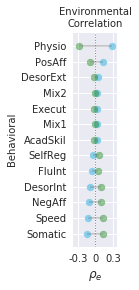

In [259]:
# set up fig
dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 20 * scale_factor
f = plt.figure(figsize=(mm2in(width),mm2in(height)))
gs = gridspec.GridSpec(ncols=1, nrows=13, hspace=0)
ax_individual = f.add_subplot(gs[:, 0])

# Select only cluster 2 and 8
df = RhoE_df[['GeMetSub_2','GeMetSub_8']]

# Reorder it following the values of the first value:
ordered_df_e = df.sort_values(by='GeMetSub_2')
my_range=range(1,len(df.index)+1)


 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.hlines(y=my_range, xmin=ordered_df_e['GeMetSub_2'], xmax=ordered_df_e['GeMetSub_8'], color='grey', alpha=0.4)
plt.scatter(ordered_df_e['GeMetSub_2'], my_range, color='skyblue', alpha=1, label='GeMetSub_2',)
plt.scatter(ordered_df_e['GeMetSub_8'], my_range, color='green', alpha=0.4 , label='GeMetSub_8')
plt.legend()
 
    
    
ylim = ax_individual.get_ylim()
ax_individual.vlines(0, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted')
ax_individual.set_ylim(ylim)
#ax_individual.set_xlim([-0, 0.1]);
ax_individual.set_ylabel('Behavioral',fontsize=10)
ax_individual.set_xlabel('')
ax_individual.set_xlabel(r"$\rho_e $", labelpad=5, fontsize=12)
ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((-0.3, 0, 0.3))
ax_individual.set_xticklabels((-0.3, 0, 0.3))
#ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('Environmental\nCorrelation', fontsize=10);
# ax_individual.set_yticklabels(ordered_df_e.index.values, fontsize=10);
plt.yticks(my_range, ordered_df_e.index.get_values(),fontsize = 10);
f.savefig(os.path.join(path_root,'subtypes_scores/26-10-2016/Figures/task_pleio/EnvCorr_association.svg'),dpi=dpi, transparent=True, pad_inches=0)

# # Add title and axis names
# #plt.yticks(my_range, ordered_df_e.index.get_values(),fontsize = 10)
# ylim = ax_individual.get_ylim()
# ax_individual.set_yticklabels(ordered_df_e.index.get_values(), fontsize=10)
# ax_individual.set_ylim(ylim)
# plt.xlabel('Value of the variables')
# ax_individual.set_title('network models', fontsize=10)
# ax_individual.vlines(0, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted',)
# ax_individual.set_ylabel('Behavioral',fontsize=10)
# ax_individual.legend_.remove()

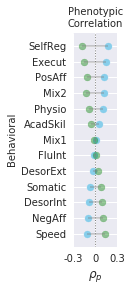

In [244]:
# set up fig
dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 20 * scale_factor
f = plt.figure(figsize=(mm2in(width),mm2in(height)))
gs = gridspec.GridSpec(ncols=1, nrows=13, hspace=0)
ax_individual = f.add_subplot(gs[:, 0])

# Select only cluster 2 and 8
df = RhoP_df[['GeMetSub_2','GeMetSub_8']]

# Reorder it following the values of the first value:
ordered_df_p = df.sort_values(by='GeMetSub_2')
my_range=range(1,len(df.index)+1)


 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.hlines(y=my_range, xmin=ordered_df_p['GeMetSub_2'], xmax=ordered_df_p['GeMetSub_8'], color='grey', alpha=0.4)
plt.scatter(ordered_df_p['GeMetSub_2'], my_range, color='skyblue', alpha=1, label='GeMetSub_2',)
plt.scatter(ordered_df_p['GeMetSub_8'], my_range, color='green', alpha=0.4 , label='GeMetSub_8')
plt.legend()
 
    
    
ylim = ax_individual.get_ylim()
ax_individual.vlines(0, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted')
ax_individual.set_ylim(ylim)
#ax_individual.set_xlim([-0, 0.1]);
ax_individual.set_ylabel('Behavioral',fontsize=10)
ax_individual.set_xlabel('')
ax_individual.set_xlabel(r"$\rho_p $", labelpad=5, fontsize=12)
ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((-0.3, 0, 0.3))
ax_individual.set_xticklabels((-0.3, 0, 0.3))
#ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('Phenotypic\nCorrelation', fontsize=10);
# ax_individual.set_yticklabels(ordered_df_p.index.values, fontsize=10);
plt.yticks(my_range, ordered_df_p.index.get_values(),fontsize = 10);
f.savefig(os.path.join(path_root,'subtypes_scores/26-10-2016/Figures/task_pleio/PhenCorr_association.svg'),dpi=dpi, transparent=True, pad_inches=0)

# # Add title and axis names
# #plt.yticks(my_range, ordered_df_p.index.get_values(),fontsize = 10)
# ylim = ax_individual.get_ylim()
# ax_individual.set_yticklabels(ordered_df_p.index.get_values(), fontsize=10)
# ax_individual.set_ylim(ylim)
# plt.xlabel('Value of the variables')
# ax_individual.set_title('network models', fontsize=10)
# ax_individual.vlines(0, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted',)
# ax_individual.set_ylabel('Behavioral',fontsize=10)
# ax_individual.legend_.remove()

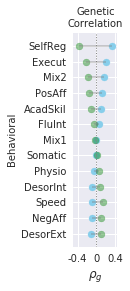

In [252]:
# set up fig
dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 20 * scale_factor
f = plt.figure(figsize=(mm2in(width),mm2in(height)))
gs = gridspec.GridSpec(ncols=1, nrows=13, hspace=0)
ax_individual = f.add_subplot(gs[:, 0])

# Select only cluster 2 and 8
df = RhoG_df[['GeMetSub_2','GeMetSub_8']]

# Reorder it following the values of the first value:
ordered_df_g = df.sort_values(by='GeMetSub_2')
my_range=range(1,len(df.index)+1)


 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.hlines(y=my_range, xmin=ordered_df_g['GeMetSub_2'], xmax=ordered_df_g['GeMetSub_8'], color='grey', alpha=0.4)
plt.scatter(ordered_df_g['GeMetSub_2'], my_range, color='skyblue', alpha=1, label='GeMetSub_2',)
plt.scatter(ordered_df_g['GeMetSub_8'], my_range, color='green', alpha=0.4 , label='GeMetSub_8')
plt.legend()
 
ylim = ax_individual.get_ylim()
ax_individual.vlines(0, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted')
ax_individual.set_ylim(ylim)
#ax_individual.set_xlim([-0.8, 0.8]);
ax_individual.set_ylabel('Behavioral',fontsize=10)
ax_individual.set_xlabel('')
ax_individual.set_xlabel(r"$\rho_g $", labelpad=5, fontsize=12)
ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks(((-0.4, 0, 0.4)))
ax_individual.set_xticklabels(((-0.4, 0, 0.4)))
ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('Genetic\nCorrelation', fontsize=10);
# ax_individual.set_yticklabels(ordered_df_g.index.values, fontsize=10);
plt.yticks(my_range, ordered_df_g.index.get_values(),fontsize = 10);
f.savefig(os.path.join(path_root,'subtypes_scores/26-10-2016/Figures/task_pleio/GenCorr_association.svg'),dpi=dpi, transparent=True, pad_inches=0)


# # Add title and axis names
# #plt.yticks(my_range, ordered_df_g.index.get_values(),fontsize = 10)
# ylim = ax_individual.get_ylim()
# ax_individual.set_yticklabels(ordered_df_g.index.get_values(), fontsize=10)
# ax_individual.set_ylim(ylim)
# plt.xlabel('Value of the variables')
# ax_individual.set_title('network models', fontsize=10)
# ax_individual.vlines(0, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted',)
# ax_individual.set_ylabel('Behavioral',fontsize=10)
# ax_individual.legend_.remove()

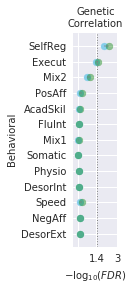

In [246]:
# set up fig
dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 20 * scale_factor
f = plt.figure(figsize=(mm2in(width),mm2in(height)))
gs = gridspec.GridSpec(ncols=1, nrows=13, hspace=0)
ax_individual = f.add_subplot(gs[:, 0])

# Select only cluster 2 and 8
df = RhoG_fdr_0_df[['GeMetSub_2','GeMetSub_8']]

# Reorder it following the values of the first value:
ordered_df_gf = df.reindex(ordered_df_g.index)
my_range=range(1,len(df.index)+1)


 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.hlines(y=my_range, xmin=ordered_df_gf['GeMetSub_2'], xmax=ordered_df_gf['GeMetSub_8'], color='grey', alpha=0.4)
plt.scatter(ordered_df_gf['GeMetSub_2'], my_range, color='skyblue', alpha=1, label='GeMetSub_2',)
plt.scatter(ordered_df_gf['GeMetSub_8'], my_range, color='green', alpha=0.4 , label='GeMetSub_8')
plt.legend()
   
    
ylim = ax_individual.get_ylim()
ax_individual.vlines(1.41, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted')
ax_individual.set_ylim(ylim)
#ax_individual.set_xlim([-0, 2]);
ax_individual.set_ylabel('Behavioral',fontsize=10)
ax_individual.set_xlabel('')
ax_individual.set_xlabel(r"$-\log_{10}(FDR) $", labelpad=5, fontsize=10)
ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((0,1.4, 3))
ax_individual.set_xticklabels(('',1.4, 3))
ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('Genetic\nCorrelation', fontsize=10);
# ax_individual.set_yticklabels(ordered_df_gf.index.values, fontsize=10);
plt.yticks(my_range, ordered_df_gf.index.get_values(),fontsize = 10);
f.savefig(os.path.join(path_root,'subtypes_scores/26-10-2016/Figures/task_pleio/FDR_GenCorr_association.svg'),dpi=dpi, transparent=True, pad_inches=0)

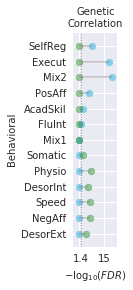

In [269]:
# set up fig
dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 20 * scale_factor
f = plt.figure(figsize=(mm2in(width),mm2in(height)))
gs = gridspec.GridSpec(ncols=1, nrows=13, hspace=0)
ax_individual = f.add_subplot(gs[:, 0])

# Select only cluster 2 and 8
df = RhoG_fdr_1_df[['GeMetSub_2','GeMetSub_8']]

# Reorder it following the values of the first value:
ordered_df_gf1 = df.reindex(ordered_df_g.index)
my_range=range(1,len(df.index)+1)


 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.hlines(y=my_range, xmin=ordered_df_gf1['GeMetSub_2'], xmax=ordered_df_gf1['GeMetSub_8'], color='grey', alpha=0.4)
plt.scatter(ordered_df_gf1['GeMetSub_2'], my_range, color='skyblue', alpha=1, label='GeMetSub_2',)
plt.scatter(ordered_df_gf1['GeMetSub_8'], my_range, color='green', alpha=0.4 , label='GeMetSub_8')
plt.legend()
   
    
ylim = ax_individual.get_ylim()
ax_individual.vlines(1.41, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted')
ax_individual.set_ylim(ylim)
#ax_individual.set_xlim([-0, 2]);
ax_individual.set_ylabel('Behavioral',fontsize=10)
ax_individual.set_xlabel('')
ax_individual.set_xlabel(r"$-\log_{10}(FDR) $", labelpad=5, fontsize=10)
ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((0,1.4, 15))
ax_individual.set_xticklabels(('',1.4, 15))
ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('Genetic\nCorrelation', fontsize=10);
# ax_individual.set_yticklabels(ordered_df_gf.index.values, fontsize=10);
plt.yticks(my_range, ordered_df_gf.index.get_values(),fontsize = 10);
f.savefig(os.path.join(path_root,'subtypes_scores/26-10-2016/Figures/task_pleio/FDR1_GenCorr_association.svg'),dpi=dpi, transparent=True, pad_inches=0)

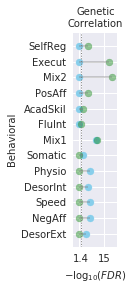

In [270]:
# set up fig
dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 20 * scale_factor
f = plt.figure(figsize=(mm2in(width),mm2in(height)))
gs = gridspec.GridSpec(ncols=1, nrows=13, hspace=0)
ax_individual = f.add_subplot(gs[:, 0])

# Select only cluster 2 and 8
df = RhoG_fdr_m1_df[['GeMetSub_2','GeMetSub_8']]

# Reorder it following the values of the first value:
ordered_df_gfm1 = df.reindex(ordered_df_g.index)
my_range=range(1,len(df.index)+1)


 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.hlines(y=my_range, xmin=ordered_df_gfm1['GeMetSub_2'], xmax=ordered_df_gfm1['GeMetSub_8'], color='grey', alpha=0.4)
plt.scatter(ordered_df_gfm1['GeMetSub_2'], my_range, color='skyblue', alpha=1, label='GeMetSub_2',)
plt.scatter(ordered_df_gfm1['GeMetSub_8'], my_range, color='green', alpha=0.4 , label='GeMetSub_8')
plt.legend()
   
    
ylim = ax_individual.get_ylim()
ax_individual.vlines(1.41, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted')
ax_individual.set_ylim(ylim)
#ax_individual.set_xlim([-0, 2]);
ax_individual.set_ylabel('Behavioral',fontsize=10)
ax_individual.set_xlabel('')
ax_individual.set_xlabel(r"$-\log_{10}(FDR) $", labelpad=5, fontsize=10)
ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((0,1.4, 15))
ax_individual.set_xticklabels(('',1.4, 15))
ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('Genetic\nCorrelation', fontsize=10);
# ax_individual.set_yticklabels(ordered_df_gf.index.values, fontsize=10);
plt.yticks(my_range, ordered_df_gf.index.get_values(),fontsize = 10);
f.savefig(os.path.join(path_root,'subtypes_scores/26-10-2016/Figures/task_pleio/FDRm1_GenCorr_association.svg'),dpi=dpi, transparent=True, pad_inches=0)

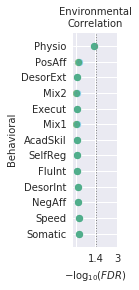

In [260]:
# set up fig
dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 20 * scale_factor
f = plt.figure(figsize=(mm2in(width),mm2in(height)))
gs = gridspec.GridSpec(ncols=1, nrows=13, hspace=0)
ax_individual = f.add_subplot(gs[:, 0])

# Select only cluster 2 and 8
df = RhoE_fdr_df[['GeMetSub_2','GeMetSub_8']]

# Reorder it following the values of the first value:
ordered_df_ef = df.reindex(ordered_df_e.index)
my_range=range(1,len(df.index)+1)


 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.hlines(y=my_range, xmin=ordered_df_ef['GeMetSub_2'], xmax=ordered_df_ef['GeMetSub_8'], color='grey', alpha=0.4)
plt.scatter(ordered_df_ef['GeMetSub_2'], my_range, color='skyblue', alpha=1, label='GeMetSub_2',)
plt.scatter(ordered_df_ef['GeMetSub_8'], my_range, color='green', alpha=0.4 , label='GeMetSub_8')
plt.legend()
   
    
ylim = ax_individual.get_ylim()
ax_individual.vlines(1.41, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted')
ax_individual.set_ylim(ylim)
#ax_individual.set_xlim([-0, 2]);
ax_individual.set_ylabel('Behavioral',fontsize=10)
ax_individual.set_xlabel('')
ax_individual.set_xlabel(r"$-\log_{10}(FDR) $", labelpad=5, fontsize=10)
ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((0,1.4, 3))
ax_individual.set_xticklabels(('',1.4, 3))
ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('Environmental\nCorrelation', fontsize=10);
# ax_individual.set_yticklabels(ordered_df_ef.index.values, fontsize=10);
plt.yticks(my_range, ordered_df_ef.index.get_values(),fontsize = 10);
f.savefig(os.path.join(path_root,'subtypes_scores/26-10-2016/Figures/task_pleio/FDR_EnvCorr_association.svg'),dpi=dpi, transparent=True, pad_inches=0)

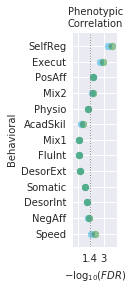

In [247]:
# set up fig
dpi=300
scale_factor = 1
height = 100 * scale_factor
width = 20 * scale_factor
f = plt.figure(figsize=(mm2in(width),mm2in(height)))
gs = gridspec.GridSpec(ncols=1, nrows=13, hspace=0)
ax_individual = f.add_subplot(gs[:, 0])

# Select only cluster 2 and 8
df = RhoP_fdr_df[['GeMetSub_2','GeMetSub_8']]

# Reorder it following the values of the first value:
ordered_df_pf = df.reindex(ordered_df_p.index)
my_range=range(1,len(df.index)+1)


 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.hlines(y=my_range, xmin=ordered_df_pf['GeMetSub_2'], xmax=ordered_df_pf['GeMetSub_8'], color='grey', alpha=0.4)
plt.scatter(ordered_df_pf['GeMetSub_2'], my_range, color='skyblue', alpha=1, label='GeMetSub_2',)
plt.scatter(ordered_df_pf['GeMetSub_8'], my_range, color='green', alpha=0.4 , label='GeMetSub_8')
plt.legend()
 
    
    
ylim = ax_individual.get_ylim()
ax_individual.vlines(1.41, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted')
ax_individual.set_ylim(ylim)
#ax_individual.set_xlim([-0, 2]);
ax_individual.set_ylabel('Behavioral',fontsize=10)
ax_individual.set_xlabel('')
ax_individual.set_xlabel(r"$-\log_{10}(FDR) $", labelpad=5, fontsize=10)
ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((0,1.4, 3))
ax_individual.set_xticklabels(('',1.4, 3))
ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('Phenotypic\nCorrelation', fontsize=10);
# ax_individual.set_yticklabels(ordered_df_pf.index.values, fontsize=10);
plt.yticks(my_range, ordered_df_pf.index.get_values(),fontsize = 10);
f.savefig(os.path.join(path_root,'subtypes_scores/26-10-2016/Figures/task_pleio/FDR_PhenoCorr_association.svg'),dpi=dpi, transparent=True, pad_inches=0)

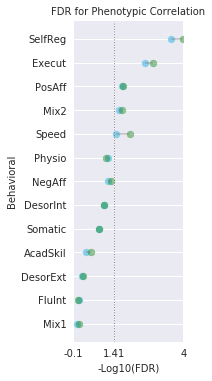

In [188]:
# set up fig
dpi=300
scale_factor = 1
height = 150 * scale_factor
width = 50 * scale_factor
f = plt.figure(figsize=(mm2in(width),mm2in(height)))
gs = gridspec.GridSpec(ncols=1, nrows=13, hspace=0)
ax_individual = f.add_subplot(gs[:, 0])

# Select only cluster 2 and 8
df = RhoP_fdr_df[['GeMetSub_2','GeMetSub_8']]

# Reorder it following the values of the first value:
ordered_df = df.sort_values(by='GeMetSub_2')
my_range=range(1,len(df.index)+1)


 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns

plt.hlines(y=my_range, xmin=ordered_df['GeMetSub_2'], xmax=ordered_df['GeMetSub_8'], color='grey', alpha=0.4)
plt.scatter(ordered_df['GeMetSub_2'], my_range, color='skyblue', alpha=1, label='GeMetSub_2',)
plt.scatter(ordered_df['GeMetSub_8'], my_range, color='green', alpha=0.4 , label='GeMetSub_8')
plt.legend()
 
    
    
ylim = ax_individual.get_ylim()
ax_individual.vlines(1.41, *ylim, linewidth=1, color='grey', zorder=1,linestyles='dotted')
ax_individual.set_ylim(ylim)
ax_individual.set_xlim([-0.1, 2]);
ax_individual.set_ylabel('Behavioral',fontsize=10)
ax_individual.set_xlabel('')
ax_individual.set_xlabel('-Log10(FDR)', labelpad=5, fontsize=10)
ax_individual.tick_params(axis='x', which='major', labelsize=10)
ax_individual.set_xticks((-0.1,1.41, 4))
ax_individual.set_xticklabels((-0.1,1.41, 4))
ax_individual.set_yticklabels(())
ax_individual.legend_.remove()
ax_individual.set_title('FDR for Phenotypic Correlation', fontsize=10);
# ax_individual.set_yticklabels(ordered_df.index.values, fontsize=10);
plt.yticks(my_range, ordered_df.index.get_values(),fontsize = 10);


/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:45: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:61: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:76: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


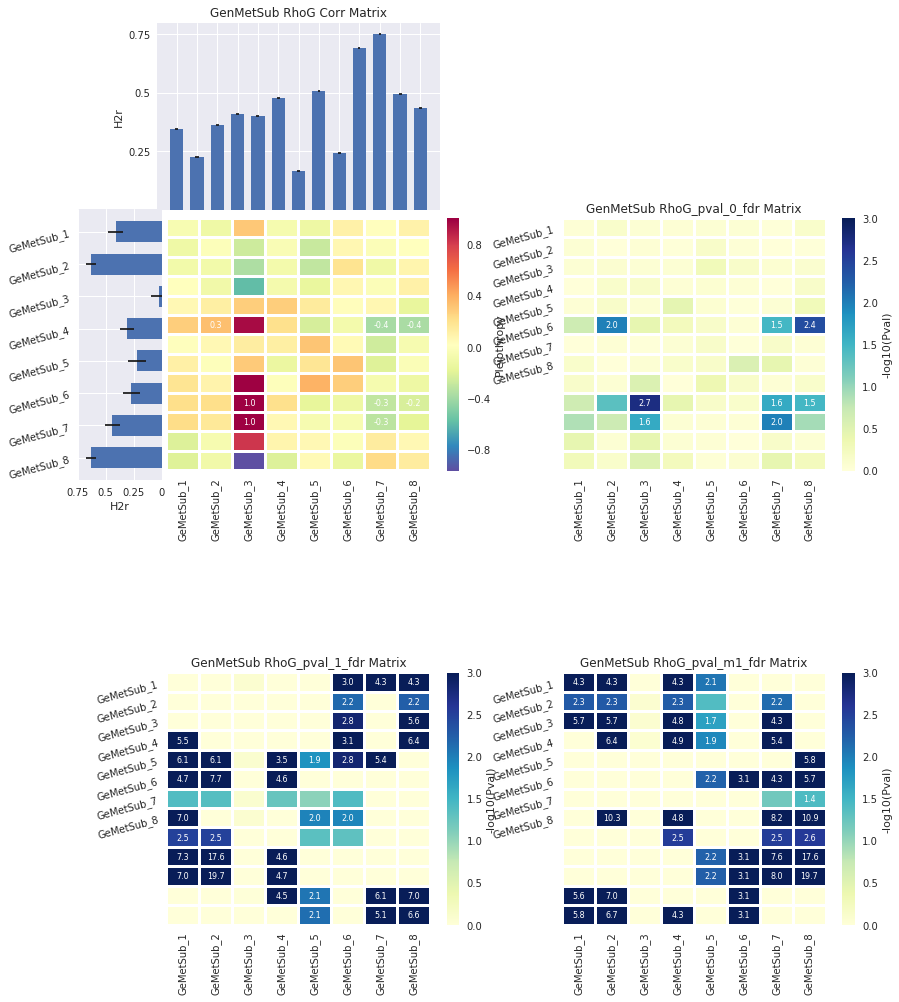

In [178]:
## Plot and save all results

# RhoG Figure
f, axes = plt.subplots(2, 2,figsize = (13,13))
f.subplots_adjust(hspace= .8)

# Save h2r to csv
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['H2r'])[list_pheno_clust+list_weight]
resul_.rename(columns = dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'H2r')))
# Get H2r of behavioral and subtypes
h2r_subt_df = resul_[list_weight] #Subtypes
h2r_behav_df  = resul_.drop(list_weight,axis=1) #Behavioral

# plot subtype H2r horizontal bar plot 
ax1 =f.add_axes([0.03,0.6,0.09,0.29])
y_pos1 = np.arange(len(list_weight))[::-1]
ax1.barh(y_pos1,-h2r_subt_df.loc['h2r'],xerr= h2r_subt_df.loc['std'],align ='center',height = 0.65)
ax1.set_xticks([0,-.25,-.5,-.75,-1])
ax1.set_xticklabels([0,.25,.5,.75,1])
ax1.set_xlim(-0.75,0)
ax1.set_xlabel('H2r')
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(list_weight, rotation=15)

# plot behavioral H2r horizontal bar plot 
ax2 =f.add_axes([0.115,0.889,0.302,0.2])
y_pos2 = np.arange(len(h2r_behav_df.columns.get_values()))
ax2.bar(y_pos2,h2r_behav_df.loc['h2r'],xerr= h2r_behav_df.loc['std'],align ='center',width =0.65 )
ax2.set_xticks(y_pos2)
ax2.set_xticklabels([])
ax2.set_yticks([0,.25,.5,.75,1])
ax2.set_yticklabels(['',.25,.5,.75,1])
ax2.set_ylim(0,0.8)
ax2.set_ylabel('H2r')


# save RhoG_pval_0_fdr to csv 
resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_0_fdr'],columns=list_weight,index=list_pheno_clust)
resul_p0.rename(columns=dict_clusters,inplace=True)
resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_0_fdr')))

# plot RhoG_pval_0_fdr result
sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[0][1],vmin=0,vmax=3)
data_p0 = resul_p0.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0][1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[0][1].set_yticklabels(list_weight, rotation=15)
axes[0][1].set_title('{} RhoG_pval_0_fdr Matrix'.format(trial),y=1.1)


# Save RhoG to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG'],columns=list_weight,index=list_pheno_clust)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG')))
# plot RhoG result
sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Pleiothropy"},linewidths=2,ax=axes[0][0])
data = resul_.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0][0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[0][0].set_yticklabels(list_weight, rotation=15)
ax2.set_title('{} RhoG Corr Matrix'.format(trial),y=1.1)

# save RhoG_pval_1_fdr to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_1_fdr'],columns=list_weight,index=list_pheno_clust)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_1_fdr')))
# plot RhoG_pval_1_fdr result
sns.heatmap(resul_,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1][0],vmin=0,vmax=3)
data = resul_.as_matrix()
for y in range(data.shape[0]):
    for x in range(data.shape[1]): 
        if data[y, x] >= 1.41:
            axes[1][0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[1][0].set_yticklabels(list_weight, rotation=15)
axes[1][0].set_title('{} RhoG_pval_1_fdr Matrix'.format(trial),y=1.1)

# save RhoG_pval_m1_fdr to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_m1_fdr'],columns=list_weight,index=list_pheno_clust)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_m1_fdr')))
# plot RhoG_pval_m1_fdr result
sns.heatmap(resul_,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1][1],vmin=0,vmax=3)
data = resul_.as_matrix()
for y in range(data.shape[0]):
    for x in range(data.shape[1]): 
        if data[y, x] >= 1.41:
            axes[1][1].text(x+0.5, y+.5, '%.1f' % data[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[1][1].set_yticklabels(list_weight, rotation=15)
axes[1][1].set_title('{} RhoG_pval_m1_fdr Matrix'.format(trial),y=1.1)

# Save figure
f.savefig(os.path.join(path_pleio,'fig_RhoG_GenMetSub.svg'))

/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:126: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:145: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:173: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:193: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:219: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/yassinebha/jupyter_py3.0/lib/python3.5/site-packages/ipykernel_launcher.py:238: FutureWarning: Method .as_mat

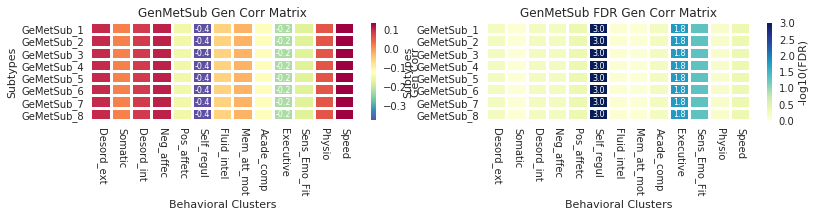

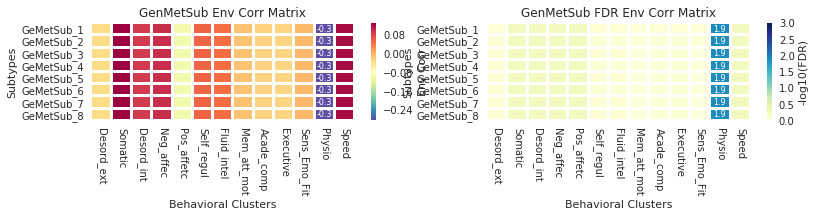

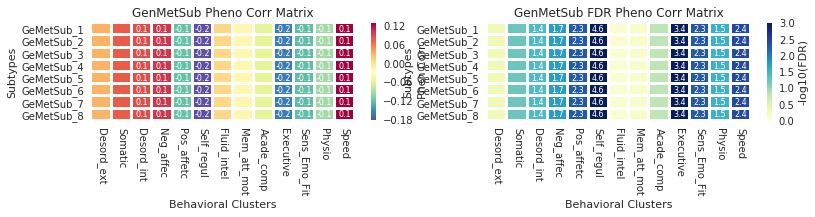

In [32]:
# Initiate no convergence result stack

No_converge = collections.namedtuple('No_converge', ['var_1',
                                                     'var_2',
                                                     'pedig_f',
                                                     'pheno_f',
                                                     'out_dir'])
no_converges = []
all_resu = dict()
H2r = dict()
trial = 'GenMetSub'
count = 0
# list subtype abreviation for figures only 
# list_sbt_dict = {'sub1':'S1', 'sub2':'S2', 'sub3':'S3', 'sub4':'S4', 'sub5':'S5'}
# list_sbt_ = [list_sbt_dict.get(item,item) for item in list_sbt ]

list_sbt = list_weight

RhoG = np.zeros((len(list_sbt),len(list_pheno_clust)))
RhoG_pval_0 = np.zeros((len(list_sbt),len(list_pheno_clust)))
RhoG_pval_1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
RhoG_pval_m1 = np.zeros((len(list_sbt),len(list_pheno_clust)))
RhoE = np.zeros((len(list_sbt),len(list_pheno_clust)))
RhoE_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))
RhoP = np.zeros((len(list_sbt),len(list_pheno_clust)))
RhoP_pval = np.zeros((len(list_sbt),len(list_pheno_clust)))

# Loop over cluster
for ix_clust, clust in enumerate(list_pheno_clust):
    for ix_subt, subt in enumerate(list_sbt):

        pheno_1 = clust
        pheno_2 = wei
        
        # output result folder
        out_dir = os.path.join(path_pleio,'{}_{}'.format(clust,wei)) 
        # pheno cov file
        pheno_f= os.path.join(out_dir,'pheno_cov.csv')
        # pedig file
        pedig_f = os.path.join(out_dir,pedig_file_ptrn)

        #grab results from text file
        fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
        for i,line in enumerate(fp):
            if 'CONVERGENCE FAILURE' in line:
                print(out_dir)
                print(line)
                count+=1
                no_converges.append(No_converge(var_1 = pheno_1,
                                                var_2 = pheno_2,
                                                out_dir = out_dir,
                                                pedig_f = pedig_f,
                                                pheno_f = pedig_f))
                break


            if 'H2r({}_norm) is '.format(pheno_1) in line:
                H2r.update({'{}'.format(pheno_1):{'h2r':float(line.strip('\n').split(' ')[3])}})

            if 'H2r({}_norm) Std. Error: '.format(pheno_1) in line:
                H2r['{}'.format(pheno_1)].update({'std':float(line.strip('\n').split(' ')[-1])})

            if 'H2r({}_norm) is '.format(pheno_2) in line:
                H2r.update({'{}'.format(subt):{'h2r':float(line.strip('\n').split(' ')[3])}})

            if 'H2r({}_norm) Std. Error: '.format(pheno_2) in line:
                H2r['{}'.format(subt)].update({'std':float(line.strip('\n').split(' ')[-1])})

            if 'RhoE is ' in line:
                RhoE[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[3])
                RhoE_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])

            if 'RhoG is ' in line:
                RhoG[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])

                #print(out_dir)
                #print(line.strip('\t ').strip('\n'))
            if 'RhoG different from zero' in line:
                RhoG_pval_0[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])

                #print(line.strip('\t '))
            if 'RhoG different from -1.0' in line:
                RhoG_pval_m1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])

            elif 'RhoG different from 1.0' in line:
                RhoG_pval_1[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])

            if 'RhoP is ' in line:
                #print(float(line.strip('\n').split(' ')[-1]))
                RhoP[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])

            if 'RhoP different from zero' in line:
                RhoP_pval[ix_subt,ix_clust] = float(line.strip('\n').split(' ')[-1])
                #print(float(line.strip('\n').split(' ')[-1]))
                break
# save matrices
all_resu.update({'{}'.format(trial):{'RhoE':RhoE,
                                     'RhoE_pval':RhoE_pval,
                                     'RhoE_pval_fdr':fdr_transf(RhoE_pval),
                                     'RhoG':RhoG,
                                     'RhoG_pval_0':RhoG_pval_0,
                                     'RhoG_pval_0_fdr':fdr_transf(RhoG_pval_0),
                                     'RhoG_pval_1':RhoG_pval_1,
                                     'RhoG_pval_1_fdr':fdr_transf(RhoG_pval_1),
                                     'RhoG_pval_m1':RhoG_pval_m1,
                                     'RhoG_pval_m1_fdr':fdr_transf(RhoG_pval_m1),
                                     'RhoP':RhoP,
                                     'RhoP_pval':RhoP_pval,
                                     'RhoP_pval_fdr':fdr_transf(RhoP_pval),
                                     'H2r':H2r,
                                     'list_pheno_clust' :list_pheno_clust,
                                     'list_weight':list_weight
                                    }})


# RhoG Figure
f, axes = plt.subplots(1, 2,figsize = (13,1.8))

# save RhoG_pval_0_fdr to csv 
resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG_pval_0_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_p0.rename(columns=dict_clusters,inplace=True)
resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG_pval_0_fdr')))

# plot RhoG_pval_0_fdr result
sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(FDR)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
data_p0 = resul_p0.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[1].set_yticklabels(list_sbt_)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
axes[1].set_ylabel('Subtypes')
axes[1].set_xlabel('Behavioral Clusters')
axes[1].set_title('{} FDR Gen Corr Matrix'.format(trial),y=1.1)


# Save RhoG to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoG'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoG')))
# plot RhoG result
sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Gen Corr"},linewidths=2,ax=axes[0])
data = resul_.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                     ha='center',va='center', color='w',fontsize=8)
axes[0].set_yticklabels(list_sbt_)
axes[0].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
axes[0].set_ylabel('Subtypes')
axes[0].set_xlabel('Behavioral Clusters')
axes[0].set_title('{} Gen Corr Matrix'.format(trial),y=1.1)


# Save figure
f.savefig(os.path.join(path_pleio,'fig_RhoG_{}.svg'.format(trial)))



# RhoE figure
f, axes = plt.subplots(1, 2,figsize = (13,1.8))

# save RhoE_pval_fdr to csv 
resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_p0.rename(columns=dict_clusters,inplace=True)
resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE_pval_fdr')))

# plot RhoE_pval_fdr result
sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(FDR)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
data_p0 = resul_p0.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[1].set_yticklabels(list_sbt_)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
axes[1].set_ylabel('Subtypes')
axes[1].set_xlabel('Behavioral Clusters')
axes[1].set_title('{} FDR Env Corr Matrix'.format(trial),y=1.1)

# save RhoE to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE')))

# plot RhoE result

sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Env Corr"},linewidths=2,ax=axes[0])
data = resul_.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[0].set_yticklabels(list_sbt_)
axes[0].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
axes[0].set_ylabel('Subtypes')
axes[0].set_xlabel('Behavioral Clusters')
axes[0].set_title('{} Env Corr Matrix'.format(trial),y=1.1)


# Save figure
f.savefig(os.path.join(path_pleio,'fig_RhoE_{}.svg'.format(trial)))

# RhoP figure 
f, axes = plt.subplots(1, 2,figsize = (13,1.8))

# save RhoP_pval_fdr to csv 
resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_p0.rename(columns=dict_clusters,inplace=True)
resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP_pval_fdr')))

# plot RhoP_pval_fdr result
sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(FDR)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
data_p0 = resul_p0.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[1].set_yticklabels(list_sbt_)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
axes[1].set_ylabel('Subtypes')
axes[1].set_xlabel('Behavioral Clusters')
axes[1].set_title('{} FDR Pheno Corr Matrix'.format(trial),y=1.1)

# save RhoP to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP')))

# plot RhoP result
sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Phen Corr"},linewidths=2,ax=axes[0])
data = resul_.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[0].set_yticklabels(list_sbt_)
axes[0].set_xticklabels(axes[1].get_xticklabels(), rotation = -90)
axes[0].set_yticklabels(list_sbt_)
axes[0].set_ylabel('Subtypes')
axes[0].set_xlabel('Behavioral Clusters')
axes[0].set_title('{} Pheno Corr Matrix'.format(trial),y=1.1)


# Save figure
f.savefig(os.path.join(path_pleio,'fig_RhoP_{}.svg'.format(trial)))


# Save all results
np.save(os.path.join(path_pleio,'pleio_all_resuts.npy'),all_resu)

In [31]:
RhoE

array([[-0.032241 ,  0.1323291,  0.0929929,  0.1007209, -0.095866 ,
         0.0569715,  0.0486505, -0.0108802],
       [-0.032241 ,  0.1323291,  0.0929929,  0.1007209, -0.095866 ,
         0.0569715,  0.0486505, -0.0108802],
       [-0.032241 ,  0.1323291,  0.0929929,  0.1007209, -0.095866 ,
         0.0569715,  0.0486505, -0.0108802],
       [-0.032241 ,  0.1323291,  0.0929929,  0.1007209, -0.095866 ,
         0.0569715,  0.0486505, -0.0108802],
       [-0.032241 ,  0.1323291,  0.0929929,  0.1007209, -0.095866 ,
         0.0569715,  0.0486505, -0.0108802],
       [-0.032241 ,  0.1323291,  0.0929929,  0.1007209, -0.095866 ,
         0.0569715,  0.0486505, -0.0108802],
       [-0.032241 ,  0.1323291,  0.0929929,  0.1007209, -0.095866 ,
         0.0569715,  0.0486505, -0.0108802],
       [-0.032241 ,  0.1323291,  0.0929929,  0.1007209, -0.095866 ,
         0.0569715,  0.0486505, -0.0108802],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.     

In [34]:
resul_[list_weight] 

,fear_emo,non_emo,math_lang,story_lang,foot_mot,hand_mot,tongue_mot,match_reson,relat_reson,mental_soc,random_soc,body0b_wm,body2b_wm,face0b_wm,face2b_wm,place0b_wm,place2b_wm,tool0b_wm,tool2b_wm
h2r,0.209884,0.033093,0.105260,0.127288,0.023195,0.057712,0.080419,0.053521,0.004874,0.081733,0.135667,0.001643,0.083397,0.250047,0.049042,0.056852,0.044401,0.103728,0.121873
std,0.054702,0.056420,0.057664,0.059732,0.058731,0.054926,0.058471,0.060365,0.007981,0.059738,0.056491,0.004730,0.058303,0.058248,0.054464,0.055479,0.054522,0.058132,0.054093


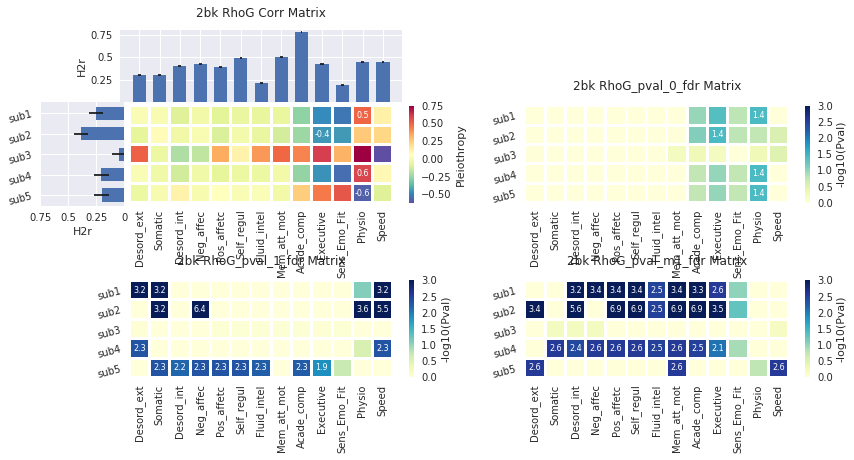

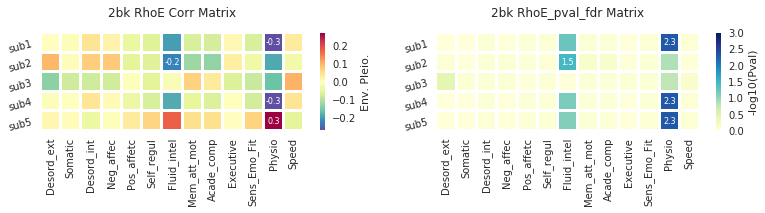

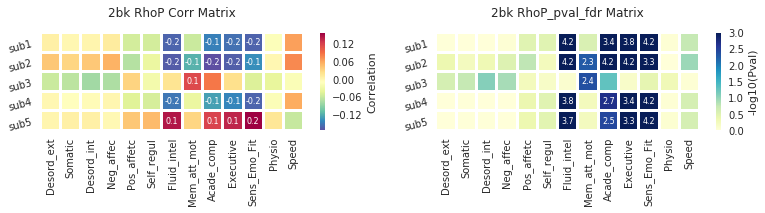

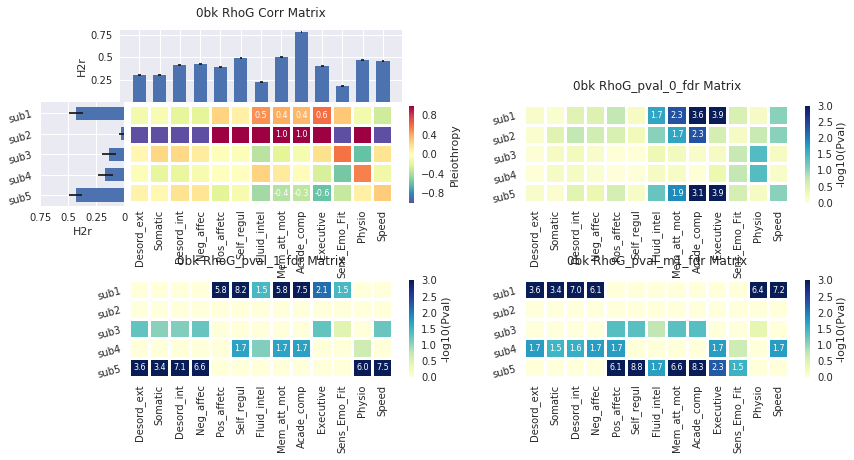

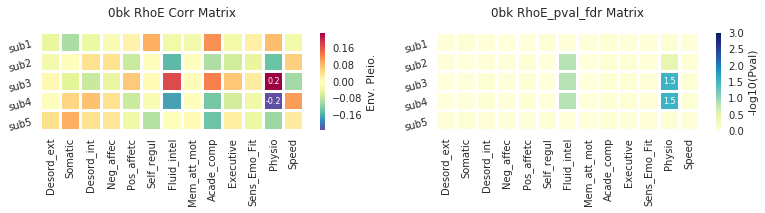

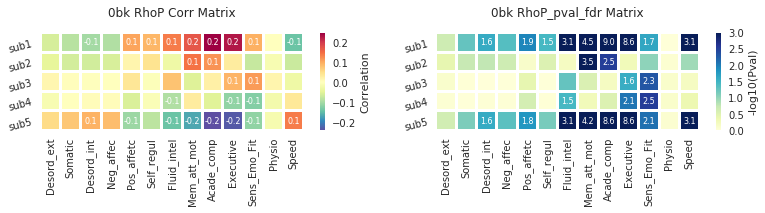

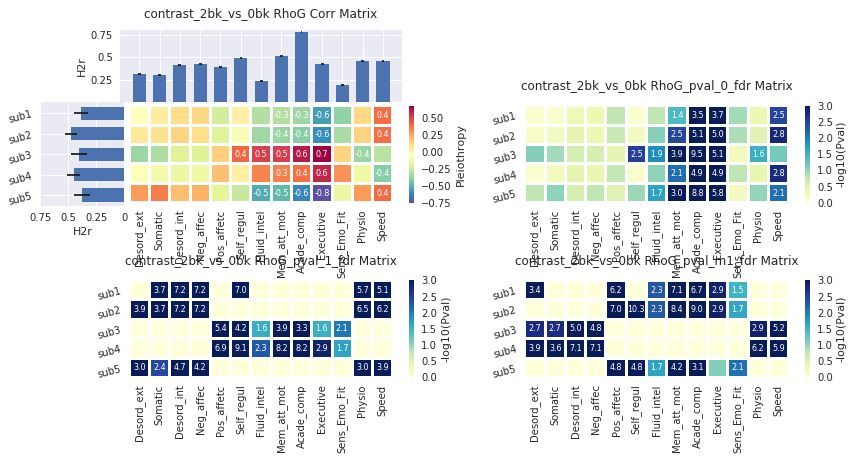

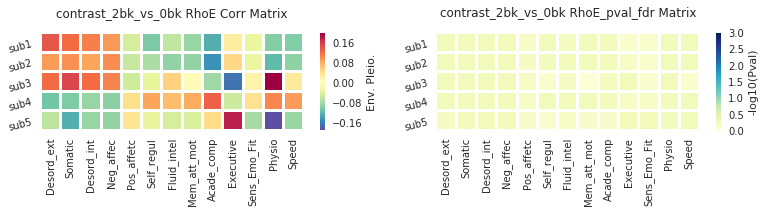

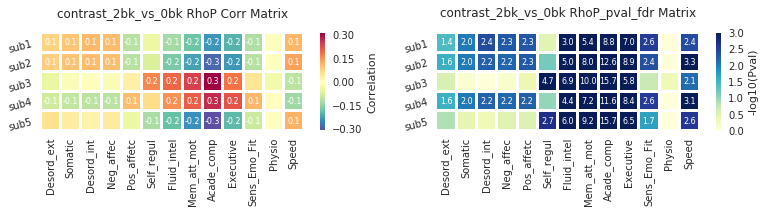

In [25]:
# RhoE figure
f, axes = plt.subplots(1, 2,figsize = (13,1.8))

# save RhoE_pval_fdr to csv 
resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_p0.rename(columns=dict_clusters,inplace=True)
resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE_pval_fdr')))

# plot RhoE_pval_fdr result
sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
data_p0 = resul_p0.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[1].set_yticklabels(list_sbt, rotation=15)
axes[1].set_title('{} RhoE_pval_fdr Matrix'.format(trial),y=1.1)

# save RhoE to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoE'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoE')))

# plot RhoE result

sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Env. Pleio."},linewidths=2,ax=axes[0])
data = resul_.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[0].set_yticklabels(list_sbt, rotation=15)
axes[0].set_title('{} RhoE Corr Matrix'.format(trial),y=1.1)


# Save figure
f.savefig(os.path.join(path_pleio,'fig_RhoE_{}.svg'.format(trial)))

# RhoP figure 
f, axes = plt.subplots(1, 2,figsize = (13,1.8))

# save RhoP_pval_fdr to csv 
resul_p0 = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP_pval_fdr'],columns=list_pheno_clust,index=list_sbt)
resul_p0.rename(columns=dict_clusters,inplace=True)
resul_p0.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP_pval_fdr')))

# plot RhoP_pval_fdr result
sns.heatmap(resul_p0,cmap="YlGnBu",cbar_kws={"label": "-log10(Pval)"},linewidths=2,ax=axes[1],vmin=0,vmax=3)
data_p0 = resul_p0.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[1].text(x+0.5, y+.5, '%.1f' % data_p0[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[1].set_yticklabels(list_sbt, rotation=15)
axes[1].set_title('{} RhoP_pval_fdr Matrix'.format(trial),y=1.1)

# save RhoP to csv 
resul_ = pd.DataFrame(all_resu['{}'.format(trial)]['RhoP'],columns=list_pheno_clust,index=list_sbt)
resul_.rename(columns=dict_clusters,inplace=True)
resul_.to_csv(os.path.join(path_pleio,'{}_{}.csv'.format(trial,'RhoP')))

# plot RhoP result
sns.heatmap(data=resul_,cmap=plt.cm.Spectral_r,cbar_kws={"label": "Correlation"},linewidths=2,ax=axes[0])
data = resul_.as_matrix()
for y in range(data_p0.shape[0]):
    for x in range(data_p0.shape[1]): 
        if data_p0[y, x] >= 1.41:
            axes[0].text(x+0.5, y+.5, '%.1f' % data[y, x],
                         ha='center',va='center', color='w',fontsize=8)
axes[0].set_yticklabels(list_sbt, rotation=15)
axes[0].set_title('{} RhoP Corr Matrix'.format(trial),y=1.1)


# Save figure
f.savefig(os.path.join(path_pleio,'fig_RhoP_{}.svg'.format(trial)))


# Save all results
np.save(os.path.join(path_pleio,'pleio_all_resuts.npy'),all_resu)

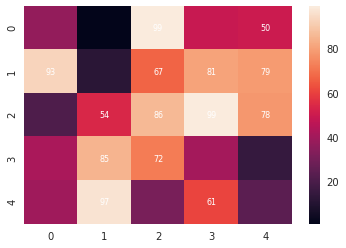

In [105]:
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt

data = np.random.randint(100, size=(5,5))
ax = sns.heatmap(data)

# put labels manually
for y in range(data.shape[0]):
    for x in range(data.shape[1]): 
        if data[y, x] >= 50:
            plt.text(x+0.5, y+.5, '%d' % data[y, x],
                     ha='center',va='center', color='w',fontsize=8)
plt.show()